In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

/tmp/ipykernel_51803/2798294591.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data/SBAnational.csv')

/tmp/ipykernel_51803/833135780.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/SBAnational.csv')


In [3]:
df.dropna(inplace=True)

In [4]:
df.isna().sum()

LoanNr_ChkDgt        0
Name                 0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
ChgOffDate           0
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
dtype: int64

In [5]:
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

In [6]:
def transform_curracy(df, columns):
    for col in columns:
        df[col] = df[col].replace(r'[\$ ,]', '', regex=True).astype(float)

def transform_date(df, columns, format='%d-%b-%y'):
    for col in columns:
        try:
            df[col] = pd.to_datetime(df[col], format=format, errors='raise')
        except ValueError:
            print('Erreur sur la date col:', col)
            pass

transform_curracy(df, ['GrAppv', 'DisbursementGross', 'SBA_Appv', 'ChgOffPrinGr'])
transform_date(df, ['ApprovalDate', 'DisbursementDate'])

df['NAICS'] = df['NAICS'].apply(lambda x: int(str(x)[:2])).astype(object)
df['ApprovalFY'] = df['ApprovalFY'].astype(str).str[0:4].astype(int)
df['Term'] = df['Term'].astype(int)
df['NoEmp'] = df['NoEmp'].astype(int)
df['CreateJob'] = df['CreateJob'].astype(int)
df['RetainedJob'] = df['RetainedJob'] .astype(int)
df['FranchiseCode'] = df['FranchiseCode'].astype('category')
df['UrbanRural'] = df['UrbanRural'].astype('category')

df['BankState'] = df['BankState'].astype('category')
df['State'] = df['State'] .astype('category')
df['Zip']= df['Zip'].astype('category')
#df['MIS_Status'] = df['MIS_Status'].astype('category')


display(df.head(2))

print(df.info())


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,1980-06-02,1980,...,N,N,24-Jun-91,1980-07-22,600000.0,$0.00,CHGOFF,208959.0,600000.0,499998.0
36,1000554001,PAUL E. & JUDY A. FAATZ,KINSMAN,OH,44428,CORTLAND SAVINGS & BK. CO.,OH,0,1997-02-28,1997,...,N,Y,18-Apr-02,1997-06-30,47000.0,$0.00,CHGOFF,14084.0,47000.0,37600.0


<class 'pandas.core.frame.DataFrame'>
Index: 160871 entries, 6 to 899162
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      160871 non-null  int64         
 1   Name               160871 non-null  object        
 2   City               160871 non-null  object        
 3   State              160871 non-null  category      
 4   Zip                160871 non-null  category      
 5   Bank               160871 non-null  object        
 6   BankState          160871 non-null  category      
 7   NAICS              160871 non-null  object        
 8   ApprovalDate       160871 non-null  datetime64[ns]
 9   ApprovalFY         160871 non-null  int64         
 10  Term               160871 non-null  int64         
 11  NoEmp              160871 non-null  int64         
 12  NewExist           160871 non-null  float64       
 13  CreateJob          160871 non-null  int64        

In [7]:
# Secteurs du NAICS
secteurs = {
    11 : 'Agriculture, forest, fishing',
    21 : 'Mining, oil, Gaz',
    22 : 'Utilities',
    23 : 'Construction',
    31 : 'Manufacturing',
    32 : 'Manufacturing',
    33 : 'Manufacturing',
    42 : 'Wolesale trade',
    44 : 'Retail trade',
    45 : 'Retail trade',
    48 : 'Transportation and warehousing',
    49 : 'Transportation and warehousing',
    51 : 'Information',
    52 : 'Finance and insurance',
    53 : 'Real estate and rental, leasing',
    54 : 'Professional, scientific, technical services',
    55 : 'Management of companies and entreprises',
    56 : 'Administrative and support',
    61 : 'Educational services',
    62 : 'Health care and social',
    71 : 'Arts, entertainment',
    81 : 'Other services',
    92 : 'Public administration'
}

In [8]:
# Colonne qui indique les secteurs du NAICS
df['Sectors'] = df['NAICS'].map(secteurs)

In [9]:
df['Sectors']

6                         NaN
36                        NaN
43                        NaN
58               Construction
60        Arts, entertainment
                 ...         
899131           Construction
899138                    NaN
899143           Construction
899153                    NaN
899162                    NaN
Name: Sectors, Length: 160871, dtype: object

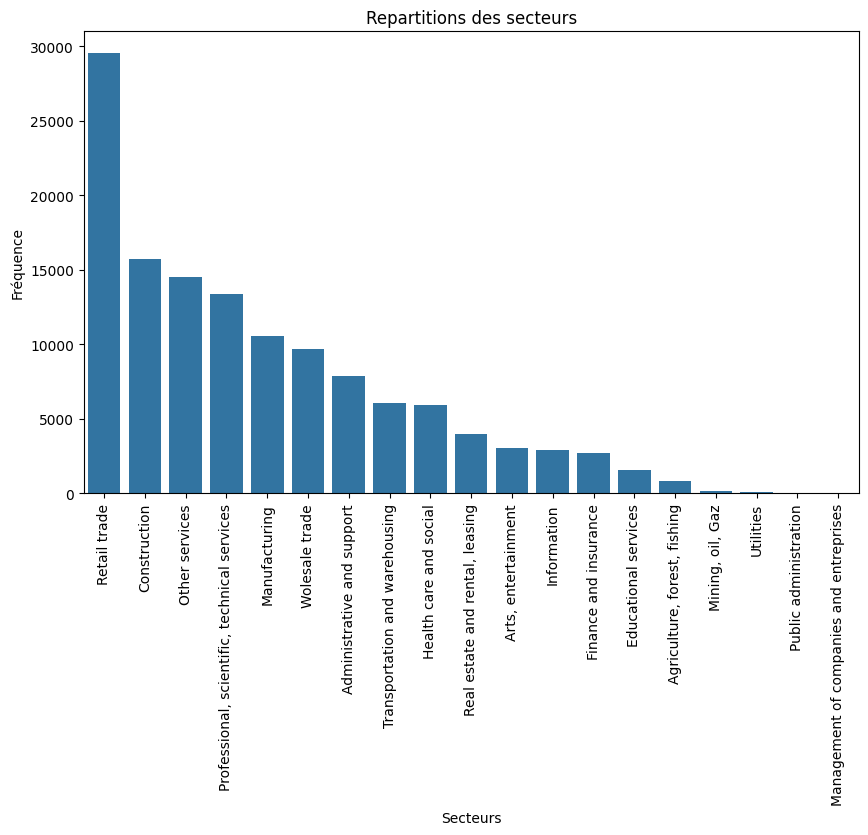

In [10]:
sector_counts = df['Sectors'].value_counts()

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.title('Repartitions des secteurs')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

In [16]:
from feature_engine.imputation import CategoricalImputer
from sklearn.preprocessing import LabelBinarizer

imputer = CategoricalImputer(imputation_method='frequent', variables=['MIS_Status'])
df = imputer.fit_transform(df)

df.MIS_Status = LabelBinarizer().fit_transform(df.loc[:,['MIS_Status']])
df.MIS_Status = df.MIS_Status.astype('category')

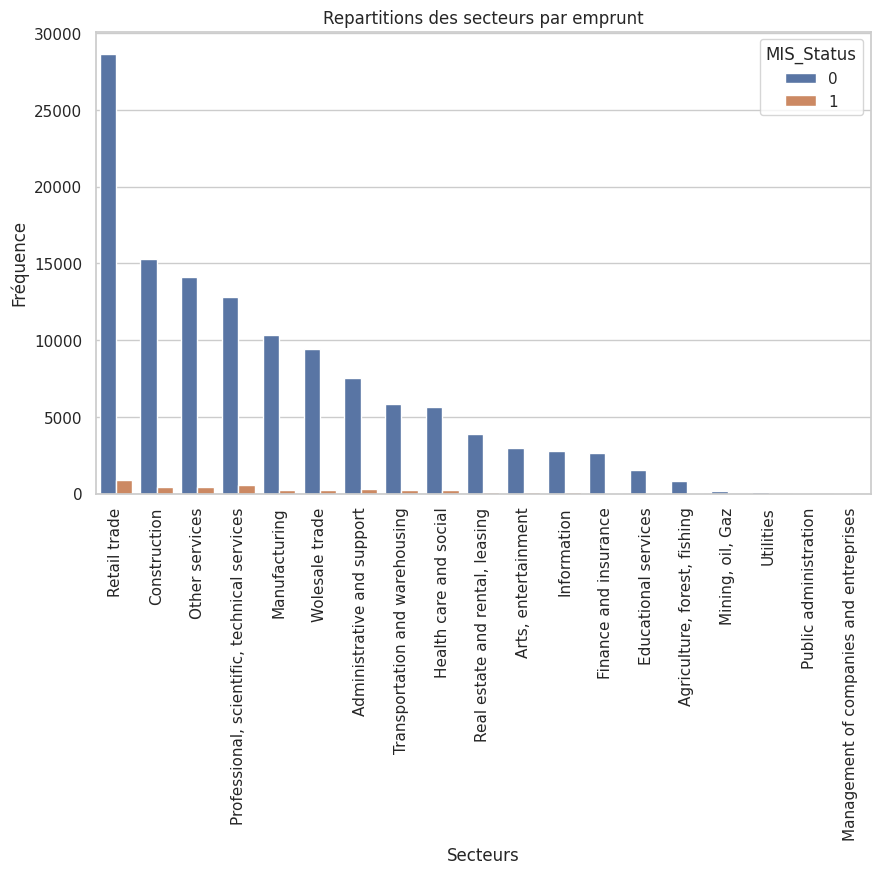

In [19]:
sector_counts = df['Sectors'].value_counts()
order = sector_counts.index

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.countplot(x='Sectors', hue='MIS_Status', data=df, order=order)
plt.title('Repartitions des secteurs par emprunt')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

In [13]:
df['LowDoc'] = df['LowDoc'].replace({'[C,S,A,R,1,0]': np.nan})

# Remplacement de 'N' par 0 et 'Y' par 1
df['LowDoc'] = df['LowDoc'].replace({'N': 0, 'Y': 1})

# Remplacement des valeurs différentes de 0 et 1 par NaN
df['LowDoc'] = np.where((df['LowDoc'] != 0) & (df['LowDoc'] != 1), np.nan, df['LowDoc'])
df['LowDoc'] = np.where( (df.GrAppv >= 150000), 0, 1)

df.dropna(subset=['LowDoc'], inplace=True)
df['LowDoc'] = df['LowDoc'].astype(int)

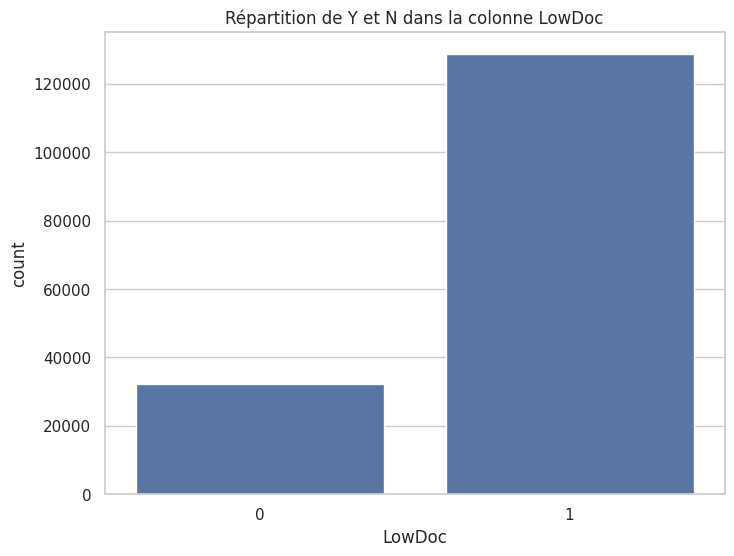

LowDoc
1    128619
0     32252
Name: count, dtype: int64

In [14]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x=df['LowDoc'], data=df)

plt.title('Répartition de Y et N dans la colonne LowDoc')
plt.show()
df['LowDoc'].value_counts()

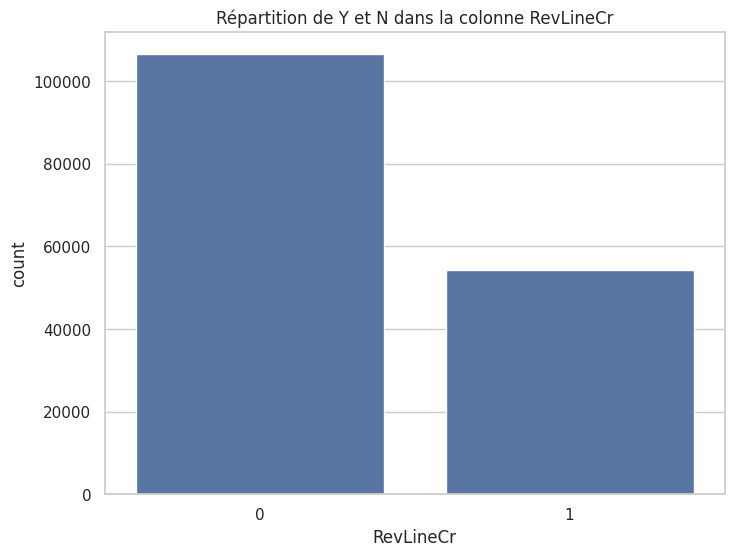

[0 1]


In [15]:
from feature_engine.imputation import RandomSampleImputer
#Corrige la colonne RevLineCr
# Remplacement des valeurs 'N' par 0 et 'Y' par 1
df['RevLineCr'] = df['RevLineCr'].replace({'N': 0, 'Y': 1})

# Remplacement des chaînes '0' par 0 et '1' par 1
df['RevLineCr'] = df['RevLineCr'].replace({'0': 0, '1': 1})

#  Remplacement des valeurs différentes de 0 et 1 par NaN
df['RevLineCr'] = np.where((df['RevLineCr'] != 0) & (df['RevLineCr'] != 1), np.nan, df['RevLineCr'])

imputer = RandomSampleImputer()

result = imputer.fit_transform(df.loc[:,['RevLineCr']])
df.RevLineCr = result['RevLineCr']
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='RevLineCr', data=df)

plt.title('Répartition de Y et N dans la colonne RevLineCr')
plt.show()
print(df['RevLineCr'].unique())